In [1]:
%run preamble_2.py
%matplotlib inline

!mkdir -p images tables results

from IPython.display import HTML

In [2]:
#
# /getStats Dataset
#
DS_NAME="API Latencies"
FILENAME="datasets/{}-{}.npy".format(6 * 7 * 24, 60 * 10)
DS_DATA = np.load(FILENAME, allow_pickle=True)
DS_QUANTILES = [0, .25, 0.5, 0.75, .9, .95, .99, .995, .999, .9999, .99999, 1 ]

In [3]:
# prom
CLASSES[1].thresholds = np.array([ 0, 1, 10, 100, 1000, 2000, 5000, 8000, 9000, 10000 ])

In [4]:
STATS = evaluate_all(DS_DATA, DS_QUANTILES)

# exact
Insert .........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
save_results(STATS, DS_NAME)

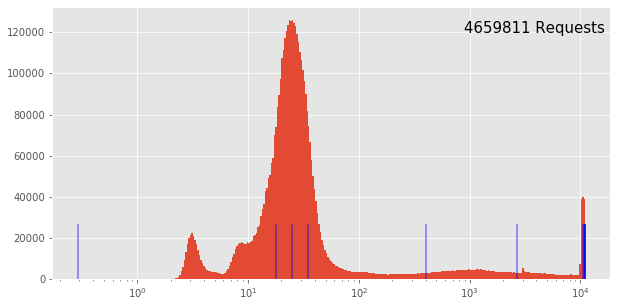

In [6]:
total = np.concatenate(DS_DATA)

xmin=1
xmax=11000
X = total
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
ax.hist(X, bins=np.exp(np.linspace(np.log(xmin), np.log(xmax), 300)));
ax.text(0.99, 0.95, '{} Requests'.format(len(X)), horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=15)

Qs = [STATS["exact"]["quantiles"][q] for q in DS_QUANTILES ]
for y in Qs: ax.axvline(y, color="blue", alpha=.5, ymax=0.2)

plt.xscale("log")

plt.savefig("images/dist_" + DS_NAME)